In [9]:
!pip install kaggle

In [10]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d ferno2/training1600000processednoemoticoncsv

 99% 80.0M/80.9M [00:06<00:00, 18.4MB/s]
100% 80.9M/80.9M [00:06<00:00, 13.1MB/s]


In [14]:
!unzip /content/training1600000processednoemoticoncsv.zip

Archive:  /content/training1600000processednoemoticoncsv.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
from wordcloud import WordCloud

In [16]:
data=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin',names=['polarity','id','date','query','user','text'])

In [17]:
data=data.sample(frac=1)
data=data[:200000]

In [18]:
data.shape

(200000, 6)

In [19]:
data.head(10)

,polarity,id,date,query,user,text
1117314,4,1973399895,Sat May 30 11:04:27 PDT 2009,NO_QUERY,karisheadspace,@kemoore Be sure and pick up a T-shirt that sa...
20685,0,1557128068,Sun Apr 19 02:10:09 PDT 2009,NO_QUERY,CHRISTYSEMIGLIA,I'm so Tired ...
769650,0,2301526773,Tue Jun 23 15:33:35 PDT 2009,NO_QUERY,Teerenee,So ur not going to wait til the weekend @DjMuh...
1557955,4,2185710519,Mon Jun 15 17:47:28 PDT 2009,NO_QUERY,fa_jen2004,Headed to Amys for The Bachelorette!!
924574,4,1755030930,Sun May 10 08:04:14 PDT 2009,NO_QUERY,rachelr1977,@amyjfisher indeed. they're having quite the d...
458179,0,2071813018,Sun Jun 07 19:57:48 PDT 2009,NO_QUERY,OurFriend_Rawr_,@raytoro Will you please kidnap/adopt me? Plea...
643449,0,2235774886,Fri Jun 19 02:02:36 PDT 2009,NO_QUERY,caaraaa,i miss kuya and papa. they're leaving bangkok...
1286581,4,2002266746,Tue Jun 02 03:41:43 PDT 2009,NO_QUERY,guitar4993,"Well I am, I'm ready to be new again Taking ba..."
44246,0,1676804153,Fri May 01 23:15:32 PDT 2009,NO_QUERY,wackyjacqui,my poor dog has anxiety she can't be left alo...
752368,0,2286438295,Mon Jun 22 16:26:49 PDT 2009,NO_QUERY,nj_joe,@Jerseygal71 Sorry to hear that. Hope he gets...


In [20]:
data['polarity'].unique()

array([4, 0])

In [21]:
data['polarity']=data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
1117314,1,1973399895,Sat May 30 11:04:27 PDT 2009,NO_QUERY,karisheadspace,@kemoore Be sure and pick up a T-shirt that sa...
20685,0,1557128068,Sun Apr 19 02:10:09 PDT 2009,NO_QUERY,CHRISTYSEMIGLIA,I'm so Tired ...
769650,0,2301526773,Tue Jun 23 15:33:35 PDT 2009,NO_QUERY,Teerenee,So ur not going to wait til the weekend @DjMuh...
1557955,1,2185710519,Mon Jun 15 17:47:28 PDT 2009,NO_QUERY,fa_jen2004,Headed to Amys for The Bachelorette!!
924574,1,1755030930,Sun May 10 08:04:14 PDT 2009,NO_QUERY,rachelr1977,@amyjfisher indeed. they're having quite the d...


In [22]:
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.500660,1.998940e+09
std,0.500001,1.936060e+08
min,0.000000,1.467811e+09
25%,0.000000,1.956878e+09
50%,1.000000,2.002143e+09
75%,1.000000,2.177113e+09
max,1.000000,2.329205e+09


In [23]:
positives=data['polarity'][data.polarity==1]
negatives=data['polarity'][data.polarity==0]
data.shape[0]

200000

In [24]:
len(positives)

100132

In [25]:
len(negatives)

99868

In [26]:
def word_count(words):
  return len(words.split())

In [27]:
data['word count']=data['text'].apply(word_count)
p=data['word count'][data.polarity ==1]
n=data['word count'][data.polarity ==0]


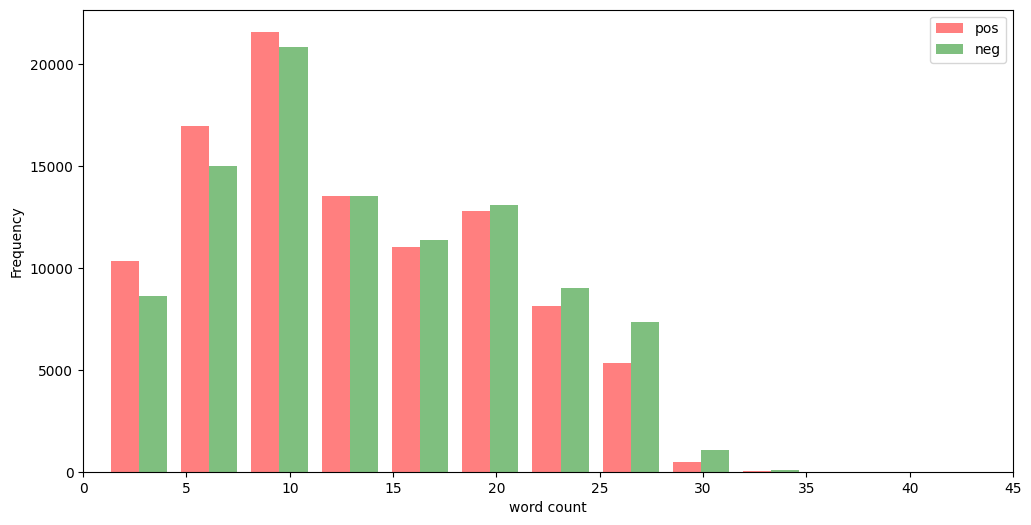

In [28]:
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('Frequency')
g=plt.hist([p,n],color=['r','g'], alpha=0.5,label=['pos','neg'])
plt.legend(loc='upper right')

In [29]:
from collections import Counter
all_words=[]
for line in list(data['text']):
  words=line.split()
  for word in words:
    if(len(word)>2):
      all_words.append(word.lower())
Counter(all_words).most_common(20)

[('the', 64766),
 ('and', 36559),
 ('you', 29621),
 ('for', 26894),
 ('have', 17945),
 ('that', 16168),
 ("i'm", 15842),
 ('just', 15784),
 ('but', 15505),
 ('with', 14282),
 ('was', 13137),
 ('not', 12774),
 ('this', 10983),
 ('get', 10168),
 ('good', 9717),
 ('like', 9474),
 ('all', 9316),
 ('are', 9299),
 ('out', 8743),
 ("it's", 8229)]

<Axes: xlabel='polarity', ylabel='Count'>

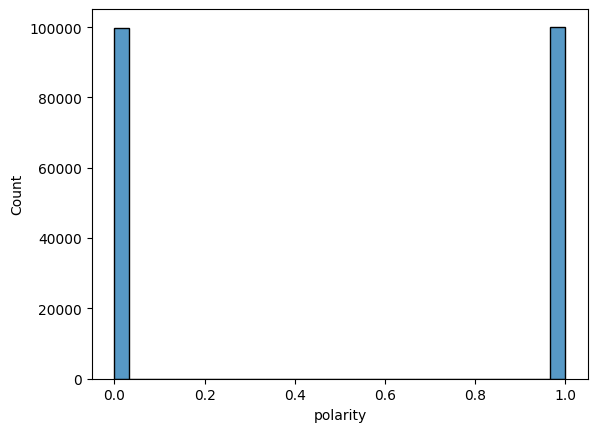

In [30]:
sns.histplot(data['polarity'])

In [31]:
data.drop(['date','query','user','word count'],axis=1,inplace=True)

In [32]:
data.head()

,polarity,id,text
1117314,1,1973399895,@kemoore Be sure and pick up a T-shirt that sa...
20685,0,1557128068,I'm so Tired ...
769650,0,2301526773,So ur not going to wait til the weekend @DjMuh...
1557955,1,2185710519,Headed to Amys for The Bachelorette!!
924574,1,1755030930,@amyjfisher indeed. they're having quite the d...


In [33]:
data.drop('id',axis=1,inplace=True)

In [34]:
(data.isnull().sum()/len(data))*100

polarity    0.0
text        0.0
dtype: float64

In [35]:
data['text']=data['text'].astype('str')

In [36]:
nltk.download('stopwords')
stopwords=set(stopwords.words('english'))
print(stopwords)

{'from', 'again', 'a', 'm', 'having', 'ain', 'ours', 'under', 'will', 'herself', 'few', "don't", 'but', 'how', 'about', 'him', 'the', 'out', 'y', 'against', 'mightn', 'd', 'shouldn', 'this', "doesn't", 'during', 'only', 'such', 'they', 'just', "haven't", 'over', 'its', 'no', 'were', 'their', 'up', 'yourselves', 'why', 'through', 'further', 'you', 'did', 'as', 'on', 'shan', 'aren', 'your', 'do', 'some', 'down', 'once', 'me', 'being', "mustn't", "you've", 'where', 'off', 'not', 't', 'for', 'his', 'hasn', "needn't", "wouldn't", "won't", "should've", 'does', 'is', 'mustn', "aren't", 'because', 'doing', "that'll", 'now', 'here', 'at', 'been', 'whom', 'be', 'he', 'there', 'ourselves', 'hadn', 'needn', 'don', 'when', 'we', 'should', 'theirs', 'more', 're', 'hers', 'by', 'wasn', 'each', 'had', 'himself', 'while', 'other', "you're", 'which', "didn't", "hadn't", 'weren', 's', 'with', 'those', 'has', "shouldn't", 'themselves', "isn't", 'before', 'have', 'my', 've', 'am', 'what', 'all', 'until', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [38]:
urlPattern =r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern='@[^\s]+'
def process_tweets(tweet):
  tweet=tweet.lower()
  tweet=tweet[1:]
  tweet=re.sub(urlPattern,'',tweet)
  tweet=re.sub(userPattern,'',tweet)
  tweet=tweet.translate(str.maketrans("","",string.punctuation))
  tokens=word_tokenize(tweet)
  final_tokens=[w for w in tokens if w not in stopwords]
  wordLemm=WordNetLemmatizer()
  finalwords=[]
  for w in final_tokens:
    if len(w)>1:
      word=wordLemm.lemmatize(w)
      finalwords.append(word)
  return " ".join(finalwords)

In [39]:
data['processed_tweets']=data['text'].apply(lambda x:process_tweets(x))

In [40]:
data['processed_tweets']

1117314    kemoore sure pick tshirt say quotvirginia may ...
20685                                                  tired
769650                             ur going wait til weekend
1557955                              eaded amys bachelorette
924574     amyjfisher indeed theyre quite discussion wan ...
                                 ...                        
1136251                               aking paper hat joe ha
1153940                                    making girl smile
1566552    iamsuperbianca heheheheehe super true 12hour m...
1598693    nathaliecaron welp green icon support fair ira...
657678     hannyvanarkel hi howre shiny ireland cloudy gr...
Name: processed_tweets, Length: 200000, dtype: object

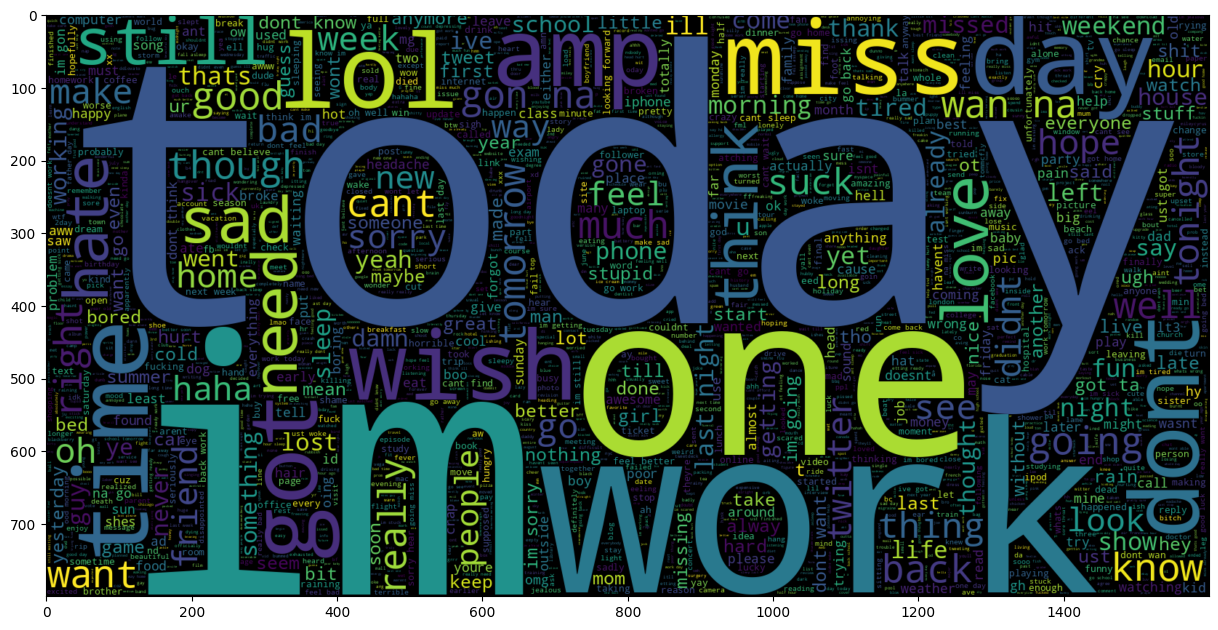

In [41]:
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000,width=1600,height=800).generate(' '.join(data[data.polarity==0].processed_tweets))
plt.imshow(wc,interpolation='bilinear')

In [42]:
x=data['processed_tweets'].values
y=data['polarity'].values

In [43]:
x.shape,y.shape

((200000,), (200000,))

In [44]:
vector=TfidfVectorizer(sublinear_tf=True)
x=vector.fit_transform(x)
x

<200000x170241 sparse matrix of type '<class 'numpy.float64'>'
	with 1495615 stored elements in Compressed Sparse Row format>

In [45]:
len(vector.get_feature_names_out())

170241

In [46]:
x.shape

(200000, 170241)

In [47]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=5)

In [48]:
x_train.shape,x_test.shape

((160000, 170241), (40000, 170241))

In [49]:
def model_Evaluate(model):
  acc_train=model.score(x_train,y_train)
  acc_test=model.score(x_test,y_test)

  print('Accuracy of model on training data : {}'.format(acc_train*100))
  print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

  y_pred=model.predict(x_test)
  print(classification_report(y_test,y_pred))
  cf_matrix=confusion_matrix(y_test,y_pred)

  categories=['Negative','Positive']
  group_names=['True Neg','False Pos','False Neg','True Pos']
  group_precentages=['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels=[f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_precentages)]
  labels=np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot=labels, cmap='Reds', fmt='',xticklabels=categories,yticklabels=categories)

  plt.xlabel("Predicted values", fontdict ={'size':14}, labelpad=10)
  plt.ylabel('Actual values', fontdict={'size':14},labelpad=10)
  plt.title('Confusion Matrix', fontdict={'size': 18}, pad=20)

Accuracy of model on training data : 83.50562500000001
Accuracy of model on testing data : 77.305 

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     19905
           1       0.76      0.80      0.78     20095

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



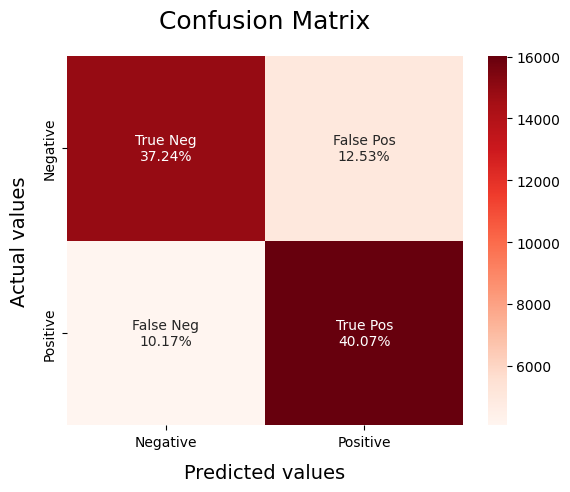

In [50]:
lg=LogisticRegression()
history =lg.fit(x_train,y_train)
model_Evaluate(lg)

Accuracy of model on training data : 93.10374999999999
Accuracy of model on testing data : 76.3425 

              precision    recall  f1-score   support

           0       0.77      0.74      0.76     19905
           1       0.76      0.78      0.77     20095

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



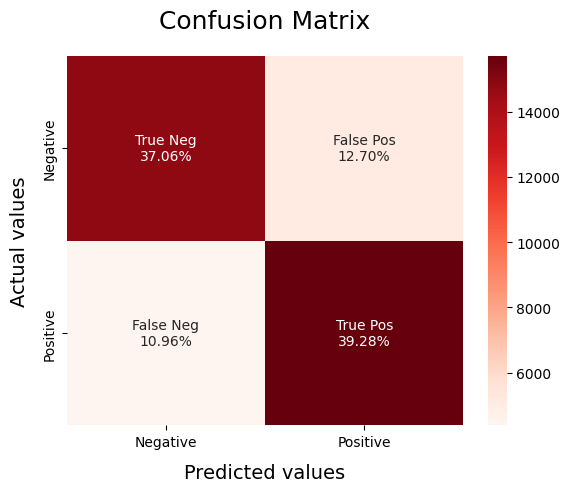

In [51]:
svm=LinearSVC()
svm.fit(x_train,y_train)
model_Evaluate(svm)

Accuracy of model on training data : 75.49375
Accuracy of model on testing data : 70.895 

              precision    recall  f1-score   support

           0       0.75      0.63      0.68     19905
           1       0.68      0.79      0.73     20095

    accuracy                           0.71     40000
   macro avg       0.71      0.71      0.71     40000
weighted avg       0.71      0.71      0.71     40000



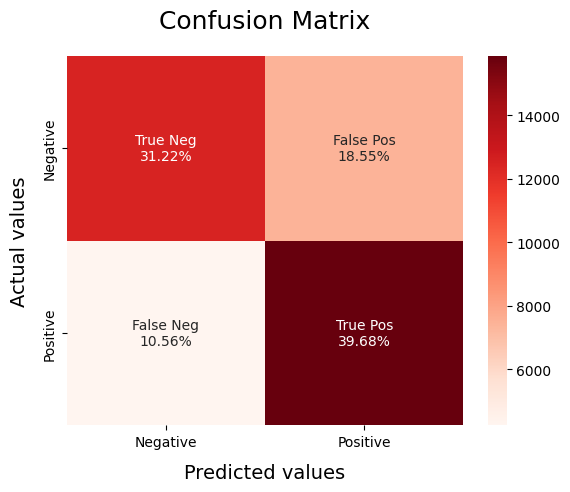

In [52]:
rf=RandomForestClassifier(n_estimators=20,criterion='entropy', max_depth=50)
rf.fit(x_train,y_train)
model_Evaluate(rf)

Accuracy of model on training data : 86.84625
Accuracy of model on testing data : 75.79249999999999 

              precision    recall  f1-score   support

           0       0.75      0.78      0.76     19905
           1       0.77      0.74      0.75     20095

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



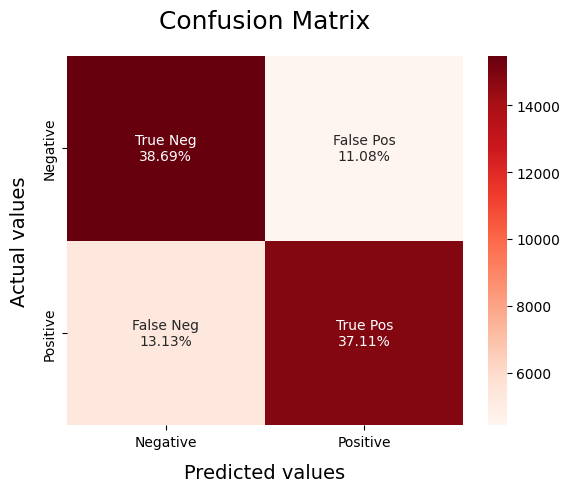

In [53]:
nb=BernoulliNB()
nb.fit(x_train,y_train)
model_Evaluate(nb)

In [54]:
import keras
keras.__version__

'2.13.1'

In [55]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words=5000
max_len=200

tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences=tokenizer.texts_to_sequences(data.processed_tweets)
tweets=pad_sequences(sequences,maxlen=max_len)
print(tweets)

[[   0    0    0 ...   85  191 1064]
 [   0    0    0 ...    0    0  108]
 [   0    0    0 ...   70  402   80]
 ...
 [   0    0    0 ... 2845 2343  264]
 [   0    0    0 ...  694  683 3588]
 [   0    0    0 ... 1856 4141 1169]]


In [56]:
x_train,x_test,y_train,y_test=train_test_split(tweets, data.polarity.values,test_size=0.2,random_state=5)

In [57]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2=Sequential()
model2.add(layers.Embedding(max_words,128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16,activation='relu'))
model2.add(layers.Dense(8,activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history=model2.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
5000/5000 [==============================] - 85s 15ms/step - loss: 0.5078 - accuracy: 0.7470 - val_loss: 0.4779 - val_accuracy: 0.7681
Epoch 2/10
5000/5000 [==============================] - 53s 11ms/step - loss: 0.4674 - accuracy: 0.7750 - val_loss: 0.4742 - val_accuracy: 0.7734
Epoch 3/10
5000/5000 [==============================] - 52s 10ms/step - loss: 0.4519 - accuracy: 0.7836 - val_loss: 0.4717 - val_accuracy: 0.7748
Epoch 4/10
5000/5000 [==============================] - 54s 11ms/step - loss: 0.4379 - accuracy: 0.7919 - val_loss: 0.4743 - val_accuracy: 0.7739
Epoch 5/10
5000/5000 [==============================] - 52s 10ms/step - loss: 0.4256 - accuracy: 0.7992 - val_loss: 0.4765 - val_accuracy: 0.7735
Epoch 6/10
5000/5000 [==============================] - 51s 10ms/step - loss: 0.4133 - accuracy: 0.8063 - val_loss: 0.4872 - val_accuracy: 0.7722
Epoch 7/10
5000/5000 [==============================] - 52s 10ms/step - loss: 0.4014 - accuracy: 0.8126 - val_loss: 0.5062 -

In [58]:
sequence=tokenizer.texts_to_sequences(['this data sciece articel is worst'])
test=pad_sequences(sequence,maxlen=max_len)
pred=model2.predict(test)

1/1 [==============================] - 1s 512ms/step


In [59]:
if pred <0.5: print('negetive')
else : print('positive')
print(pred)

negetive
[[0.00580804]]
